## <center>Elements Of Data Science - F2020</center>
# <center>Week 8: Data Cleaning and Feature Engineering<center>
### <center>11/9/2020</center>

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

sns.set_style('darkgrid')
%matplotlib inline

# TODOs

- Readings:
 - PDSH 5.9 [PCA](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
 - [Recommeded] PML Ch 8 
<br>
<br>

- HW2, Due Thurs Nov. 12th, 11:59pm
<br>

- Answer and submit Quiz 8, **Sunday Nov 15th, 11:59pm ET**

# Today

- **Data Cleaning**
 - Duplicates
 - Missing Data
 - Dummy Variables
 - Rescaling
 - Dealing With Skew
 - Removing Outliers
<br>

- **Feature Engineering**
 - Binning
 - One-Hot encoding
 - Derived
 - Unstructured Data: Natural Language Processing

<br>
<br>

# <center>Questions?</center>
<br>
<br>

# Data Cleaning
<br>

Why do we need clean data?

- Want one row per observation (remove duplicates)
- Most models cannot handle missing data (remove/fill missing)
- Most models require fixed length feature vectors (engineer features)
<br>

- Different models require different types of data (transformation)
 - Linear models: real valued features with similar scale
 - Distance based: real valued features with similar scale
 - Tree based: can handle real and categorical

# Example Data and `.info()`

In [2]:
# read in example data
df_shop = pd.read_csv('../data/flowershop_data_with_dups.csv',
                      header=0,
                      parse_dates=['purchase_date'],
                      delimiter=',')

df_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      1001 non-null   int64         
 1   lastname         1001 non-null   object        
 2   purchase_date    1001 non-null   datetime64[ns]
 3   stars            1001 non-null   int64         
 4   price            979 non-null    float64       
 5   favorite_flower  823 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 47.0+ KB


# Duplicated Data
<br>
    
- Only drop duplicates if you know data should be unique
 - Example: if there is a unique id per row

In [3]:
df_shop.duplicated().iloc[:3] # are first 3 rows duplicates?

0    False
1    False
2    False
dtype: bool

In [4]:
df_shop[df_shop.duplicated(keep='first')] # default keep first duplicated row

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
1000,1010,FERGUSON,2017-05-04,2,21.0183,daffodil


In [5]:
df_shop[df_shop.duplicated(keep=False)] # keep=False to show all duplicated rows

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
10,1010,FERGUSON,2017-05-04,2,21.0183,daffodil
1000,1010,FERGUSON,2017-05-04,2,21.0183,daffodil


# Duplicated Data for Subset of Columns

In [6]:
df_shop[df_shop.duplicated(subset='purchase_id',keep=False)].sort_values(by='purchase_id')

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
10,1010,FERGUSON,2017-05-04,2,21.018300,daffodil
1000,1010,FERGUSON,2017-05-04,2,21.018300,daffodil
100,1101,WEBB,2017-07-13,2,8.004356,iris
101,1101,BURKE,2017-08-16,4,18.560260,daffodil


# Dropping Duplicates

In [7]:
df_new = df_shop.drop_duplicates(subset=None     # consider subset of columns
                                 ,keep='first'   # or 'last' or False)
                                 ,inplace=False)

In [8]:
# or can use inplace to change the original dataframe
df_shop.drop_duplicates(subset=None,keep='first',inplace=True)

In [9]:
# drop rows with duplicates considering only a subset of columns
df_shop = df_shop.drop_duplicates(subset=['purchase_id'])

# Missing Data

- Reasons for missing data
 - Sensor error (random?)
 - Data entry error (random?)
 - Survey-subject decisions (non-random?)
 - etc.
<br>

- Dealing with missing data
 - Drop rows
 - Impute from data in the same column
 - Infer from other features
 - Fill with adjacent data

# Missing Data in Pandas: `np.nan`
<br>

- Missing values represented by `np.nan` : Not A Number

In [10]:
# Earlier, we saw missing values in the dataframe summary
df_shop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      999 non-null    int64         
 1   lastname         999 non-null    object        
 2   purchase_date    999 non-null    datetime64[ns]
 3   stars            999 non-null    int64         
 4   price            977 non-null    float64       
 5   favorite_flower  821 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 54.6+ KB


In [11]:
np.nan == np.nan

False

# `.isna()` and `.notna()`

In [12]:
df_shop.loc[20:21,'price']

20          NaN
21    10.525912
Name: price, dtype: float64

In [13]:
# isna returns True where data is missing, False otherwise
df_shop.loc[20:21,'price'].isna()

20     True
21    False
Name: price, dtype: bool

In [14]:
# notna returns True where data is NOT missing, False otherwise
df_shop.loc[20:21,'price'].notna()

20    False
21     True
Name: price, dtype: bool

In [15]:
# find rows where price is missing
df_shop[df_shop.price.isna()].head()

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
20,1020,CLARK,2017-01-05,3,NaN,NaN
41,1041,PETERS,2017-02-01,4,NaN,orchid
54,1054,GREEN,2017-02-13,5,NaN,daffodil
63,1063,BARNETT,2017-08-27,4,NaN,gardenia
145,1145,CARROLL,2017-07-29,3,NaN,tulip


# Missing Data: Drop Rows

In [16]:
df_shop.shape

(999, 6)

In [17]:
# drop rows with nan in any column
df_shop.dropna().shape

(801, 6)

In [18]:
# drop only rows with nan in price using subset
df_shop.dropna(subset=['price']).shape

(977, 6)

In [19]:
# drop only rows with nans in all columns
df_shop.dropna(how='all').shape

(999, 6)

# Missing Data: Drop Rows Cont.

In [20]:
# save a new dataframe with dropped rows
df_new = df_shop.dropna()
df_new.shape

(801, 6)

In [21]:
# drop rows in current dataframe
df_new = df_shop.copy()
df_new.dropna(inplace=True)
df_new.shape

(801, 6)

In [22]:
# How many total nan's?
df_shop.isna().sum().sum()

200

# Missing Data: Drop Rows
<br>

- Pros:
 - easy to do
 - simple to understand
<br>
<br>

- Cons:
 - potentially large data loss

# Missing Data: Impute
<br>

- Impute: fill in with some data
<br>

- Use .fillna()
<br>

- Common filler values:
 - mean
 - median
 - "most frequent"
 - 0

# Missing Data: Impute

In [23]:
df_shop.price.mean()

23.408197893394266

In [24]:
# make a copy to keep our original df
df_new = df_shop.copy()

In [25]:
# fill missing price with mean of price
df_new.price = df_shop.price.fillna(df_shop.price.mean())

In [26]:
# check to make sure all nulls filled
sum(df_new.price.isna())

0

In [27]:
# inplace works here as well
df_new.price.fillna(df_new.price.mean(),inplace=True)

In [28]:
# can also handle categorical data
df_new.favorite_flower.fillna(df_shop.favorite_flower.mode().iloc[0],inplace=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      999 non-null    int64         
 1   lastname         999 non-null    object        
 2   purchase_date    999 non-null    datetime64[ns]
 3   stars            999 non-null    int64         
 4   price            999 non-null    float64       
 5   favorite_flower  999 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 94.6+ KB


# Missing Data: Impute
<br>

- Pros:
 - easy to do
 - simple to understand
<br>
<br>

- Cons:
 - may missing feature interactions

# Missing Data: Infer
<br>

- Predict values of missing features using a model
- Ex: Can we predict price based on any of the other features?
- Additional feature engineering may be needed prior to this

In [29]:
from sklearn.linear_model import LinearRegression

df_tmp = df_shop.copy()

not_missing = df_tmp.price.notna()
missing = df_tmp.price.isna()

lr = LinearRegression().fit(df_tmp.loc[not_missing,['stars']],
                            df_tmp[not_missing].price)

df_tmp.loc[missing,'price'] = lr.predict(df_tmp.loc[missing,['stars']])

# Missing Data: Adjacent Data
<br>

- Use `.fillna()` with method:
 - ffill: propagate last valid observation forward to next valid
 - bfill: use next valid observation to fill gap backwards
<br>

- Use when there is reason to believe data not i.i.d. (eg: timeseries)

In [30]:
df_shop.price.loc[19:21]

19    20.451789
20          NaN
21    10.525912
Name: price, dtype: float64

In [31]:
df_shop.price.fillna(method='ffill').loc[19:21]

19    20.451789
20    20.451789
21    10.525912
Name: price, dtype: float64

# Missing Data: Dummy Columns
<br>

- Data may be missing for a reason!
- Capture "missing" before filling

In [32]:
# storing a column of 1:missing, 0:not-missing
df_new['price_isnull'] = df_shop.price.isna().astype(int)

# can now fill missing values
df_new['price'] = df_shop.price.fillna(df_shop.price.mean())

# Rescaling
<br>

- Often need features to be in the same scale
- Methods of rescaling
 - Standardization (z-score)
 - Min-Max rescaling
 - others...

In [33]:
# load taxi data
taxi = pd.read_csv('../data/yellow_tripdata_2017-01_subset10000rows.csv',
                parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

# create trip_duration
taxi['trip_duration'] = (taxi.tpep_dropoff_datetime - taxi.tpep_pickup_datetime).dt.seconds

# select subset
df_taxi = taxi[(taxi.trip_duration < 3600) & (taxi.tip_amount > 0) & (taxi.tip_amount < 10)]

In [34]:
df_taxi[['trip_duration','tip_amount']].agg(['mean','std','min','max'],axis=0)

,trip_duration,tip_amount
mean,765.030683,2.405944
std,496.831608,1.552848
min,2.000000,0.010000
max,3556.000000,9.990000


# Rescaling: Standardization
<br>

- rescale to 0 mean, standard deviation of 1
 - X_scaled = (X - X.mean()) / X.std()

In [35]:
from sklearn.preprocessing import StandardScaler

# instantiate
ss = StandardScaler()

# fit to the data
ss.fit(df_taxi[['trip_duration','tip_amount']])

# transform the data
X = ss.transform(df_taxi[['trip_duration','tip_amount']])
X[:2]

array([[-0.50127786, -0.48040987],
       [-0.16512088, -0.90546941]])

In [36]:
df_new = pd.DataFrame(X,columns=['trip_duration_scaled','tip_amount_scaled'])
df_new.agg(['mean','std','min','max'],axis=0)

,trip_duration_scaled,tip_amount_scaled
mean,4.622808e-17,-1.358307e-16
std,1.000080e+00,1.000080e+00
min,-1.535917e+00,-1.543059e+00
max,5.617987e+00,4.884357e+00


# Rescaling: Min-Max

- rescale values between 0 and 1
- X_scaled = (X - X.min()) / (X.max() - X.min())
- removes negative values

In [37]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(df_taxi[['trip_duration','tip_amount']])

df_new = pd.DataFrame(X,columns=['trip_duration_scaled','tip_amount_scaled'])
df_new.agg(['mean','std','min','max'])

,trip_duration_scaled,tip_amount_scaled
mean,0.214696,0.240075
std,0.139795,0.155596
min,0.000000,0.000000
max,1.000000,1.000000


# Dealing with Skew
<br>

- Many models expect "normal", symmetric data (ex: linear models)
- Highly skewed: tail has larger effect on model (outliers?)
- Transform with `log` or `sqrt`


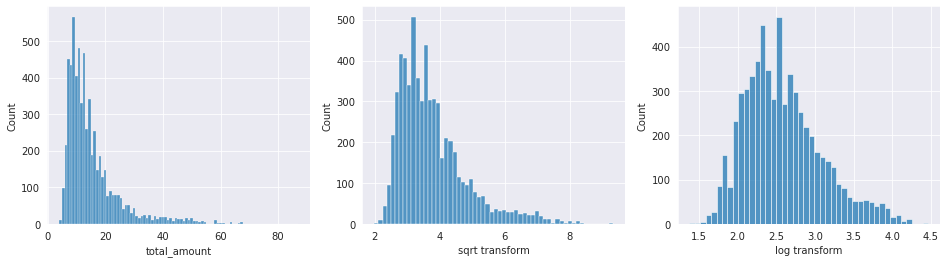

In [38]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
sns.histplot(x=df_taxi.total_amount, ax=ax[0]);
sns.histplot(x=df_taxi.total_amount.apply(np.sqrt), ax=ax[1]); ax[1].set_xlabel('sqrt transform');
sns.histplot(x=df_taxi.total_amount.apply(np.log),  ax=ax[2]); ax[2].set_xlabel('log transform');

# Outliers

- Similar to missing data:
 - human data entry error
 - instrument measurement errors
 - data processing errors
 - natural deviations


<div align="center"><img src="images/outlier-detection-1.png" width="600px"></div>

# Outliers
<br>

- Why worry about them?
 - can give misleading results
 - can indicate issues in data/measurement
<br>
<br>

- Detecting Outliers
 - understand your data!
 - visualizations
 - 1.5*IQR
 - z-scores
 - etc..

# Detecting Outliers

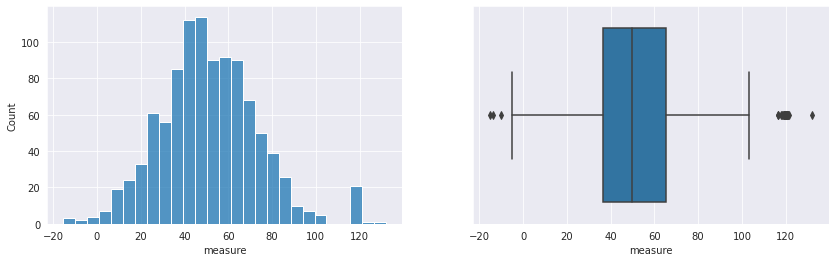

In [39]:
df = pd.DataFrame(np.random.normal(50,20,1000), columns=['measure'])
df = df.append(pd.DataFrame(np.random.normal(120,1,20), columns=['measure']))

fig,ax = plt.subplots(1,2, figsize=(14,4))
sns.histplot(x=df.measure,ax=ax[0]);
sns.boxplot(x=df.measure,ax=ax[1]);

# Detecting Outliers with z-score

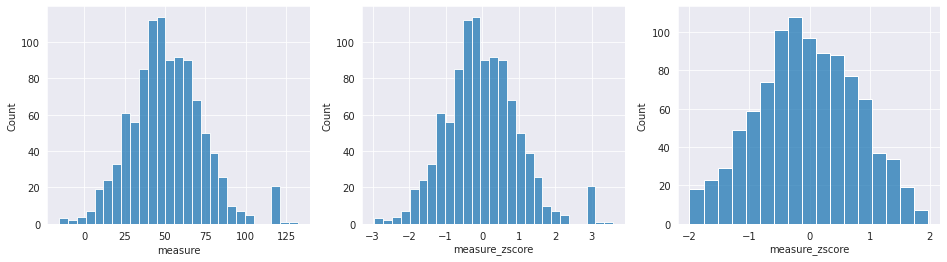

In [40]:
# zscore
df['measure_zscore'] = (df.measure - df.measure.mean()) / df.measure.std()

fig, ax = plt.subplots(1,3,figsize=(16,4))
sns.histplot(x=df.measure,ax=ax[0]);
sns.histplot(x=df.measure_zscore, ax=ax[1]);

keep_idx = np.abs(df.measure_zscore) < 2
sns.histplot(x=df[keep_idx].measure_zscore, ax=ax[2]);

# Other Outlier Detection Methods
<br>

- Many more parametric and non-parametric methods
 - Standardized Residuals
 - DBScan
 - ElipticEnvelope
 - IsolationForest
 - other Anomoly Detection techniques
 - See [sklearn docs on Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html) for more details

# Dealing with Outliers
<br>

- How to deal with outliers?
 - drop data
 - treat as missing
 - encode with dummy variable first?

# Data Cleaning Review

- duplicate data
- missing data
- rescaling
- dealing with skew
- outlier detection

# Feature Engineering
<br>

- Binning
- One-Hot encoding
- Derived

# Binning
<br>

- Transform continuous features to categorical
- Use:
 - pd.cut
 - sklearn.preprocessing.KBinsDiscretizer (combined binning and one-hot-encoding)

In [41]:
trip_duration_bins = [df_taxi.trip_duration.min(),
                      df_taxi.trip_duration.median(),
                      df_taxi.trip_duration.quantile(0.75),
                      df_taxi.trip_duration.max(),
                     ]

In [42]:
df_new = df_taxi.copy()
df_new['trip_duration_binned'] = pd.cut(df_taxi.trip_duration,           
                                        bins=trip_duration_bins,          # can pass bin edges or number of bins
                                        labels=['short','medium','long'],
                                        right=True,                       # all bins right-inclusive
                                        include_lowest=True               # first interval left-inclusive
                                       )
df_new[['trip_duration','trip_duration_binned']].iloc[:4]


,trip_duration,trip_duration_binned
1,516,short
2,683,medium
7,834,medium
8,298,short


# One-Hot Encoding

- Encode categorical features for models that can't handle categorical (eg. Linear)
- One column per category, '1' in only one column per row
- Use `pd.get_dummies()` or `sklearn.preprocessing.OneHotEncoder`

In [43]:
pd.get_dummies(df_new.trip_duration_binned, prefix='trip_duration').iloc[:3]

,trip_duration_short,trip_duration_medium,trip_duration_long
1,1,0,0
2,0,1,0
7,0,1,0


In [44]:
df_new.join(pd.get_dummies(df_new.trip_duration_binned, prefix='trip_duration')).iloc[:3,-5:]

,trip_duration,trip_duration_binned,trip_duration_short,trip_duration_medium,trip_duration_long
1,516,short,1,0,0
2,683,medium,0,1,0
7,834,medium,0,1,0


In [45]:
pd.get_dummies(df_new).iloc[:3,-7:]

,total_amount,trip_duration,store_and_fwd_flag_N,store_and_fwd_flag_Y,trip_duration_binned_short,trip_duration_binned_medium,trip_duration_binned_long
1,9.96,516,1,0,1,0,0
2,10.30,683,1,0,0,1,0
7,16.64,834,1,0,0,1,0


# One-Hot Encoding with sklearn

In [46]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories=[['short','medium','long']],  # or leave as 'auto'
                    sparse=False,
                    handle_unknown='ignore')                 # will raise error otherwise

ohe.fit(df_new[['trip_duration_binned']])
ohe.categories_

[array(['short', 'medium', 'long'], dtype=object)]

In [47]:
ohe.transform(df_new[['trip_duration_binned']])[:3]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

# Bin and One-Hot Encode with sklearn

In [48]:
from sklearn.preprocessing import KBinsDiscretizer

# NOTE: We're not setting the bin edges explicitly
#       For control over bin edges, use Binarizer
kbd = KBinsDiscretizer(n_bins=3,
                       encode="onehot",     # or onehot (sparse), ordinal
                       strategy="quantile", # or uniform or kmeans (clustering)
                      ).fit(df_new[['trip_duration']])

kbd.bin_edges_

array([array([2.000e+00, 4.780e+02, 8.700e+02, 3.556e+03])], dtype=object)

In [49]:
df_new[['trip_duration']].head(3)

,trip_duration
1,516
2,683
7,834


In [50]:
kbd.transform(df_new[['trip_duration']])[:3]

<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [51]:
kbd.transform(df_new[['trip_duration']])[:3].todense()

matrix([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

# Derived Features
<br>

- Anything that is a transformation of our data
- This is where the money is!

# Polynomial Features

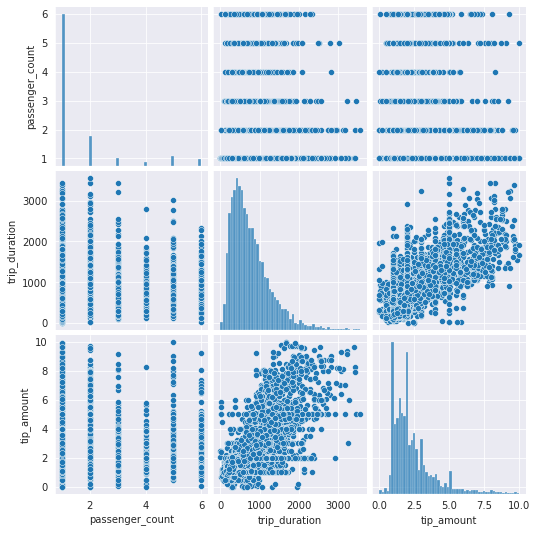

In [52]:
sns.pairplot(df_taxi[['passenger_count','trip_duration','tip_amount']]);

# Polynomial Features Continued

In [53]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2,
                        include_bias=False)
X_new = pf.fit_transform(df_taxi[['passenger_count','trip_duration']])

new_columns = ['passenger_count','trip_duration','passenger_count^2','passenger_count*trip_duration','trip_duration^2']
pd.DataFrame(X_new[3:5],columns=new_columns)

,passenger_count,trip_duration,passenger_count^2,passenger_count*trip_duration,trip_duration^2
0,3.0,298.0,9.0,894.0,88804.0
1,1.0,396.0,1.0,396.0,156816.0


# Natural Language Processing (NLP)
<br>

- Many NLP Tasks
 - topic modeling
 - sentiment analysis
 - entity recognition
 - machine translation
 - natural language generation
 - question answering
 - relationship extraction
 - automatic summarization
 - ...
<br>

- All depend on extracting features from unstructured text data

# NLP: The Corpus
<br>

- **corpus:** collection of documents
- Each item a document
 - tweet
 - review
 - resume
 - book
 - article
 - sentence
 - ...

# NLP: Doc Representation

In [54]:
doc_1 = "The cat in the hat."
doc_2 = "The quick brown cat jumped over the lazy cat."
corpus = [doc_1,doc_2]

- **tokens:** strings that make up a document ('the','cat',...)
- **terms:** unique set of strings in a documents
- **vocabulary:** set of unique terms that can be in any document
- **tokenization:** process of transforming document into tokens

# NLP: Tokenization
<br>

- common tokenization method: split on whitespace

In [55]:
doc_1.split()

['The', 'cat', 'in', 'the', 'hat.']

In [56]:
doc_2.split()

['The', 'quick', 'brown', 'cat', 'jumped', 'over', 'the', 'lazy', 'cat.']

- Additional transformations depend on problem:
 - lowercase
 - remove stopwords
 - **stemming:** reduce token to stem (eg: "tokenization"->"tokeniz")
 - **lemmatization:** common form (eg: "tokenization"->"tokenize")
 - <start> and <end> tags?
 - remove special characters

# NLP: Doc Representation

- Most common representaion: Bag of Words (BOW)
 - split document into tokens
 - ignore order (lose context!)

In [57]:
sorted(doc_1.lower().replace('.','').split())

['cat', 'hat', 'in', 'the', 'the']

In [58]:
sorted(doc_2.lower().replace('.','').split())

['brown', 'cat', 'cat', 'jumped', 'lazy', 'over', 'quick', 'the', 'the']

# NLP: n-grams

- create new terms as combinations of n tokens
- captures local context
- vocabulary increases quickly
<br>

Unigrams: n = 1

In [59]:
sorted(doc_1.lower().replace('.','').split())

['cat', 'hat', 'in', 'the', 'the']

Bigrams: n = 2

In [60]:
tmp = ("<start> "+doc_1+" <end>").lower().replace('.','').split()
sorted([(tmp[i]+'_'+tmp[i+1]) for i in range(len(tmp)-1)])

['<start>_the', 'cat_in', 'hat_<end>', 'in_the', 'the_cat', 'the_hat']

# NLP: Term Frequency
<br>

- **Term Frequency (TF):** Number of times a particular term occurs in a document


In [61]:
tokens = []
for doc in corpus:
    tokens.extend(doc.lower().replace('.','').split())
vocab = sorted(list(set(tokens)))
vocab

['brown', 'cat', 'hat', 'in', 'jumped', 'lazy', 'over', 'quick', 'the']

In [62]:
termfreq = np.zeros((len(corpus),len(vocab)))
for doc_idx,doc in enumerate(corpus):
    for term_idx,term in enumerate(vocab):
        for token in doc.lower().replace('.','').split():
            if term == token:
                termfreq[doc_idx,term_idx]+=1
df_termfreq = pd.DataFrame(termfreq,index=['doc1','doc2'],columns=vocab)
df_termfreq

,brown,cat,hat,in,jumped,lazy,over,quick,the
doc1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
doc2,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0


# NLP: Term Frequency
<br>

- **Document Frequency (DF):** Number of documents a term occurs in

In [63]:
docfreq = df_termfreq.sum()
docfreq.sort_values(ascending=False)

the       4.0
cat       3.0
quick     1.0
over      1.0
lazy      1.0
jumped    1.0
in        1.0
hat       1.0
brown     1.0
dtype: float64

# Stopwords

- **stopwords:** terms that (generally) have high DF and aren't informative
- ex: 'a', 'about','above',...
- often removed prior to analysis

In [64]:
stopwords = ['the','a', 'an']

tokens = []
for doc in corpus:
    tokens.extend(doc.lower().replace('.','').split())
vocab = sorted(list(set(tokens)))
vocab = [x for x in vocab if x not in stopwords]
vocab

['brown', 'cat', 'hat', 'in', 'jumped', 'lazy', 'over', 'quick']

# NLP: CountVectorizer

In [65]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words=None,                 # can use 'english', but arguments against: https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words
                     ngram_range=(1,1),               # only unigrams
                     token_pattern= r'(?u)\b\w\w+\b', # at least one word-character surrounded by boundaries
                     min_df=1,                        # has to occur in at least one document
                     max_df=1.0,                      # can occur in at most 100% of the documents
                    ) 
X = cv.fit_transform(corpus)
cv.vocabulary_

{'the': 8,
 'cat': 1,
 'in': 3,
 'hat': 2,
 'quick': 7,
 'brown': 0,
 'jumped': 4,
 'over': 6,
 'lazy': 5}

In [66]:
X

<2x9 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [67]:
X.todense() # term frequencies

matrix([[0, 1, 1, 1, 0, 0, 0, 0, 2],
        [1, 2, 0, 0, 1, 1, 1, 1, 2]])

# NLP: Tf-Idf
<br>

- What if some terms are still uninformative?
- Can we downweight terms that are in many documents?

- **Term Frequency - Inverse Document Frequency (TfIdf)**
 - `tfidf(t,d) = tf(t, d) * idf(t)`
 - `idf(t) = log [ n / docfreq(t) ] + 1`

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus)
X.todense()

matrix([[0.        , 0.33425073, 0.46977774, 0.46977774, 0.        ,
         0.        , 0.        , 0.        , 0.66850146],
        [0.33241213, 0.47302794, 0.        , 0.        , 0.33241213,
         0.33241213, 0.33241213, 0.33241213, 0.47302794]])

# NLP: Example 20Newsgroups

In [69]:
from sklearn.datasets import fetch_20newsgroups

ngs = fetch_20newsgroups()

# grab 100 docs
docs = ngs['data'][:100]
docs[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [70]:
cv = TfidfVectorizer(ngram_range=(1,2), #unigrams + bigrams
                     stop_words=None,
                     min_df=2,
                     max_df=.8
                    ).fit(docs)
X = cv.transform(docs)
X.shape

(100, 3894)

In [71]:
list(cv.stop_words_)[:5]

['playing rambo',
 'be suspended',
 'risk radioactive',
 'beaverton',
 'space radar']

# Predicting with Train/Test Split
<br>
- When training a model for prediction

<div align="center"><img src="images/modelpredict_pipeline.png" width="600px"></div>

# Transforming with Train/Test Split
<br>
- When performing data transformation

<div align="center"><img src="images/transformation_pipeline.png" width="600px"></div>

# Next

- Feature Selection
- Dimensionality Reduction
- Topic Modeling

<br>
<br>

# <center>Questions?</center>
<br>
<br>